In [25]:
import copy
import logging
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rosbags.rosbag2 import Reader

from evo.tools import file_interface, plot
from evo.tools import settings
from evo.core import sync, metrics
from evo.core.metrics import PoseRelation

In [26]:
# Configuration
BAG_PATH = "../../bags/dvl_dropouts_tm"
TRUTH_TOPIC = "/auv0/odometry/truth"
ESTIMATE_TOPICS = [
    "/auv0/odometry/global",
    "/auv0/odometry/global_tm",
    "/auv0/odometry/global_ekf",
    "/auv0/odometry/global_ukf",
]
OUTPUT_DIR = Path(BAG_PATH)
print(f"Saving results to: {OUTPUT_DIR.resolve()}")

Saving results to: /home/snelsondurrant/coug_fgo_dev/bags/dvl_dropouts_tm


In [17]:
def load_trajectories(bag_path, truth_topic, estimate_topics):
    trajectories = {}
    try:
        with Reader(bag_path) as reader:
            traj_ref = file_interface.read_bag_trajectory(reader, truth_topic)

            for est_topic in estimate_topics:
                try:
                    traj_est = file_interface.read_bag_trajectory(reader, est_topic)
                    
                    traj_ref_synced, traj_est_synced = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.1)
                    traj_est_aligned = copy.deepcopy(traj_est_synced)
                    traj_est_aligned.align(traj_ref_synced, correct_scale=False, correct_only_scale=False)
                    
                    trajectories[est_topic] = traj_est_aligned
                    
                except Exception as e:
                    print(f"Skipping {est_topic}: {e}")
                    continue
    except Exception as e:
        print(f"Error opening bag: {e}")
        
    return trajectories, traj_ref

def calculate_metrics(trajectories, traj_ref):
    results = []
    
    for name, traj in trajectories.items():
        traj_ref_synced, traj_est_aligned_synced = sync.associate_trajectories(traj_ref, traj, max_diff=0.1)
        
        row = {"Topic": name}
        
        # APE (Absolute Pose Error)
        for rel, metric_name in [(PoseRelation.translation_part, "APE-Trans"), (PoseRelation.rotation_angle_deg, "APE-Rot")]:
            metric = metrics.APE(rel)
            metric.process_data((traj_ref_synced, traj_est_aligned_synced))
            row[metric_name] = metric.get_statistic(metrics.StatisticsType.rmse)
            
        # RPE (Relative Pose Error)
        for rel, metric_name in [(PoseRelation.translation_part, "RPE-Trans"), (PoseRelation.rotation_angle_deg, "RPE-Rot")]:
            metric = metrics.RPE(rel)
            metric.process_data((traj_ref_synced, traj_est_aligned_synced))
            row[metric_name] = metric.get_statistic(metrics.StatisticsType.rmse)
            
        results.append(row)
        
    return pd.DataFrame(results).set_index("Topic")

In [18]:
aligned_trajectories, truth_ref = load_trajectories(BAG_PATH, TRUTH_TOPIC, ESTIMATE_TOPICS)
df_metrics = calculate_metrics(aligned_trajectories, truth_ref)

In [27]:
csv_path = OUTPUT_DIR / "metrics.csv"
df_metrics.to_csv(csv_path)
print(f"Metrics saved to: {csv_path}")
display(df_metrics)

Metrics saved to: ../../bags/dvl_dropouts_tm/metrics.csv


,APE-Trans,APE-Rot,RPE-Trans,RPE-Rot
Topic,,,,
/auv0/odometry/global,1.956798,2.764052,1.083086,2.829844
/auv0/odometry/global_tm,1.633931,3.799648,0.671182,3.572375
/auv0/odometry/global_ekf,153.089555,11.129858,0.219177,0.028640
/auv0/odometry/global_ukf,119.651207,14.631581,0.367474,0.050407


Plot saved to: /home/snelsondurrant/coug_fgo_dev/bags/dvl_dropouts_tm/trajectories.png


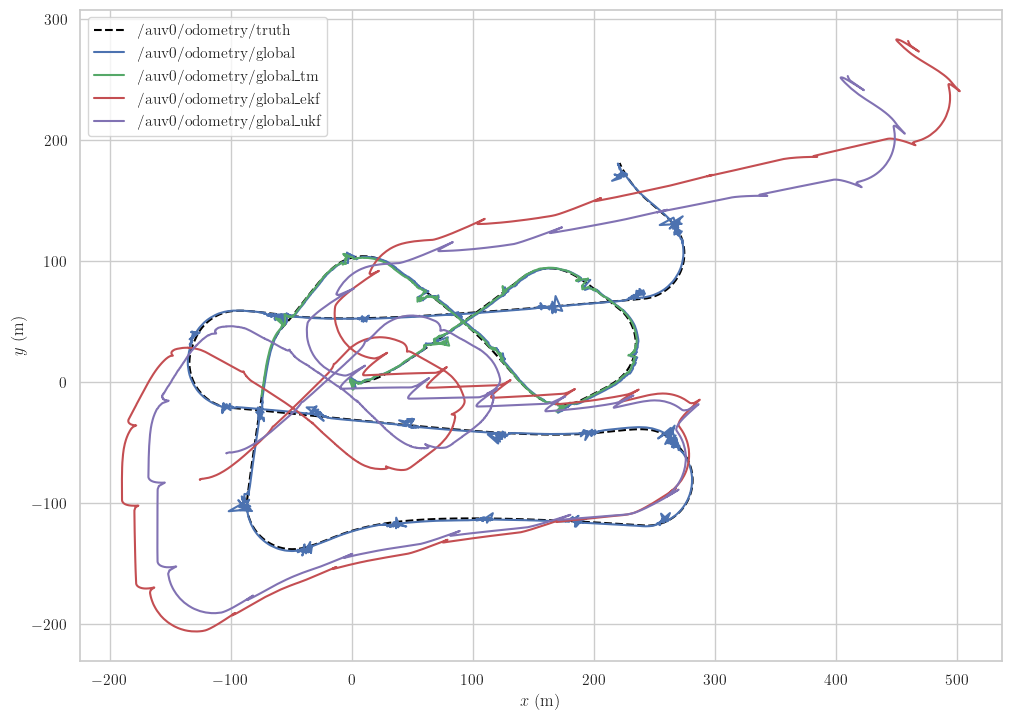

In [28]:
settings.SETTINGS.plot_seaborn_style = "whitegrid"
settings.SETTINGS.plot_usetex = True
settings.SETTINGS.plot_fontfamily = "serif"
plot.apply_settings(settings.SETTINGS)

plot_mode = plot.PlotMode.xy 
# plot_mode = plot.PlotMode.xz
# plot_mode = plot.PlotMode.yz
# plot_mode = plot.PlotMode.xyz

fig = plt.figure(figsize=(10, 8))
ax = plot.prepare_axis(fig, plot_mode)

plot.traj(ax, plot_mode, truth_ref, style="--", color="black", label=TRUTH_TOPIC)
plot.trajectories(ax, aligned_trajectories, plot_mode)

plot_path = OUTPUT_DIR / "trajectories.png"
plt.savefig(plot_path)
print(f"Plot saved to: {plot_path.resolve()}")
display(fig)
